In [1]:
import os
import spei as sp #spei package
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats as scs
from joblib import Parallel, delayed
import multiprocessing
import mhm_dataprocessing as md
import geopandas as gpd
from tqdm import tqdm  # pip install tqdm
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rio
from itertools import product
import mhm_drought_funcs as mdf
from datetime import datetime
#mdates
import matplotlib.dates as mdates

#### Open datasets

In [2]:
src = r'D:/VUB/_data/mHM_EOBS'

#Data already clipped to domain boundaries
pet = xr.open_dataset(f'{src}/pet_UTMx.nc')
pre = xr.open_dataset(f'{src}/pre_UTMx.nc')
sMI = xr.open_dataset(f'{src}/SMI.nc')
spi_3_da = xr.open_dataset(f'{src}/spi_3_hpc.nc') #implemented in the HPC
spi_1_da = xr.open_dataset(f'{src}/spi_1_hpc.nc') #implemented in the HPC
spei_1_da = xr.open_dataset(f'{src}/spei_1.nc') #implemented in the HPC
spei_3_da = xr.open_dataset(f'{src}/spei_3.nc') #implemented in the HPC


drought_ADM = pd.read_csv(os.path.join(src, 'results_ADM.txt'), index_col=0, sep="\s+")

#outputs: drought clusters
dCluster = xr.open_dataset(f'{src}/DCluster.nc')
sMI = xr.open_dataset(f'{src}/SMI.nc')
mask = xr.open_dataset(f'{src}/BE_SMI_mask.nc')

#BE shapefile
be_shp = gpd.read_file(r"W:/VUB/_main_research/mHM/mhm_belgium/be_shp/be_joined_epsg_32631.shp")

#### Clip to model domain and simulation period

In [3]:
#clip the Datasets to BE boundary
pet = md.clip_to_region(be_shp, pet)
pre = md.clip_to_region(be_shp, pre)

#slide data to start from 1970
pet = pet.sel(time=slice('1970-01-01', None))
pre = pre.sel(time=slice('1970-01-01', None))

#mask areas with constant values using data variance
pet = pet.where(pet.pet.var(dim='time') > 0.001, drop=False)
pre = pre.where(pre.pre.var(dim='time') > 0.001, drop=False)

#compute water balance (precipitatione excess) for spei
p_excess = pre.pre - pet.pet

In [4]:
#p_excess to xr dataset
p_excess = p_excess.to_dataset(name='p_excess')
#p_excess.to_netcdf(f'{src}/p_excess_BE_UTMx.nc')
# pre.to_netcdf(f'{src}/pre_BE_UTMx.nc')

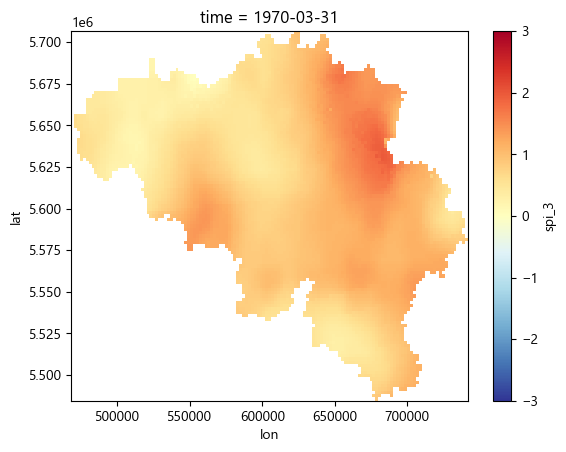

In [5]:
spi_3_da['spi_3'].isel(time=0).plot(cmap='RdYlBu_r', vmin=-3, vmax=3)

#### Clip dCluster to match extent of meteo datasets

In [6]:
#clip dCLuster using pre map
dCluster = dCluster.sel(lat=slice(pre.lat.max(), pre.lat.min()),
                        lon=slice(pre.lon.min(), pre.lon.max()))

#### GRid Cell SPI and SPEI
Run only once. The datasets will be saved as netcdf which can then imported together with the other input files.

In [7]:
# # Compute SPI for different timescales
# spi_1 = mdf.compute_SPI(pre, 'pre', 30)  # SPI-1
# #export the SPI-1 to netcdf
# spi_1.to_netcdf(f'{src}/spi_1.nc')

# # Compute SPEI for the given timescale
# spei_1 = mdf.compute_SPEI(p_excess, 'p_excess', 30)  # SPEI-1
# # Export the SPEI-1 to netcdf
# spei_1.to_netcdf(f'{src}/spei_1.nc')

#### Validate spatial datasets with timeseries

In [8]:
#3 month p_excess accumulation
timescale = 30
p_excess_accum = p_excess.rolling(time=timescale).sum()
pre_accum = pre.rolling(time=timescale).sum()

In [9]:
lat = 5589595.563692  # Example latitude in UTM
lon = 705128.602119  # Example longitude in UTM

p_excess_tx = p_excess_accum['p_excess'].sel(lat=lat, lon=lon, method='nearest').to_series().dropna()
precip_tx = pre_accum.pre.sel(lat=lat, lon=lon, method='nearest').to_series().dropna()

spi_3 = sp.spi(precip_tx, dist=scs.gamma, fit_freq="ME")
spi_3_d = sp.spi(precip_tx, dist=scs.gamma, fit_freq="ME")
spei_3 = sp.spei(p_excess_tx, fit_freq="ME")

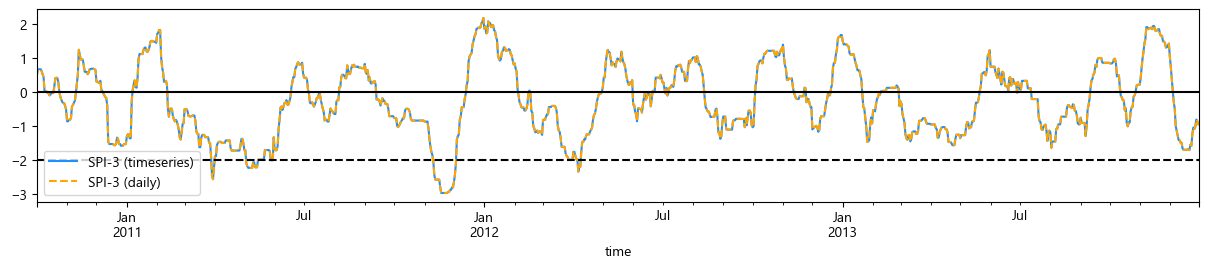

In [10]:
fig, ax = plt.subplots(figsize=(15, 2.5))
startwindow = '2010-10-01'
endwindow='2013-12-31'

#spei_da.sel(lat=lat, lon=lon, method='nearest').to_dataframe().drop(columns=['lat', 'lon'])[startwindow:endwindow].plot(ax=ax, color='blue', label='SPEI-3 (calculated)')
#spei_3[startwindow:endwindow].plot(ax=ax, color='red', ls='--', label='SPEI-3 (calculated)')

# spi_3_da.sel(lat=lat, lon=lon, method='nearest').to_dataframe().drop(columns=['lat', 'lon'])[startwindow:endwindow].plot(ax=ax, c='r')
spi_3[startwindow:endwindow].plot(ax=ax, color='dodgerblue', label='SPI-3 (timeseries)')
spi_3_d[startwindow:endwindow].plot(ax=ax, color='orange', label='SPI-3 (daily)', ls='--')

plt.axhline(-2, color='black', ls='--')
plt.axhline(0, color='black', ls='-')
plt.legend()

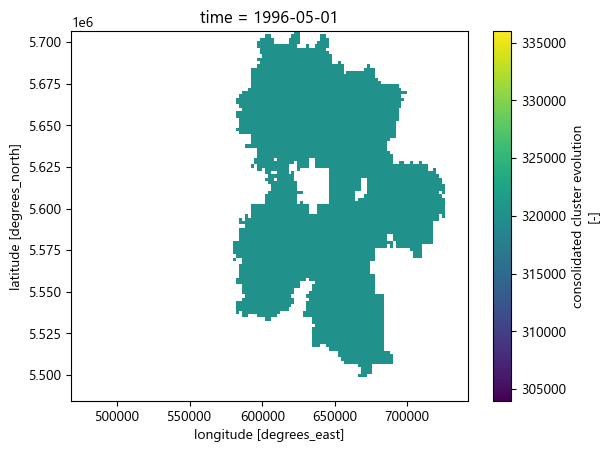

In [11]:
dCluster.sel(time=slice('1995-08-01', '1996-08-28'))['mDC'][9].plot()

#### Compare SMI and SPEI

In [12]:
#cluster_IDs for major droughts
base_date = datetime(1970, 1, 1) # simulation starts from 1970-01-01, which is mStart=1, so we use 1969-12-31 as the base date

drought_ADM = mdf.assign_date_ADM(drought_ADM, base_date)

In [13]:
#top 3 drought events earlier than 2022
drought_ADM_top = drought_ADM.nlargest(4, 'TDM').sort_values(by='TDM', ascending=False)
drought_ADM_top=drought_ADM_top[drought_ADM_top['c_Id'] != 638001] # Remove the last row with c_Id 638001 (2022 drought)

In [120]:
drought_ADM_top= drought_ADM.nlargest(6, 'TDM').sort_values(by='TDM', ascending=False)
drought_ADM_top

,c_Id,mStart,mEnd,aDD,aDA,TDM,start_month,end_month
i,,,,,,,,
107,575001,561,575,9.60832,0.64055,9193.14235,2016-09-01,2017-11-01
20,85003,70,85,10.02164,0.62635,8934.97340,1975-10-01,1977-01-01
119,638001,627,638,8.39090,0.69924,7870.74532,2022-03-01,2023-02-01
109,590001,581,590,7.31791,0.73179,7120.87778,2018-05-01,2019-02-01
60,320001,308,320,7.83329,0.60256,6177.26809,1995-08-01,1996-08-01
114,613001,604,613,5.79588,0.57959,5782.82654,2020-04-01,2021-01-01


In [121]:
#select top 3 events up to 2020
c_IDs = [85003, 575001, 590001] # Example cluster IDs for the top 5 drought events

drought_ADM_plot = drought_ADM_top[drought_ADM_top['c_Id'].isin(c_IDs)].copy()

#sort by start month
drought_ADM_plot = drought_ADM_plot.sort_values(by='start_month')

In [122]:
drought_ADM_plot

,c_Id,mStart,mEnd,aDD,aDA,TDM,start_month,end_month
i,,,,,,,,
20,85003,70,85,10.02164,0.62635,8934.97340,1975-10-01,1977-01-01
107,575001,561,575,9.60832,0.64055,9193.14235,2016-09-01,2017-11-01
109,590001,581,590,7.31791,0.73179,7120.87778,2018-05-01,2019-02-01


In [123]:
#add one monyth to the end month
drought_ADM_plot['end_month'] = drought_ADM_plot['end_month'] + pd.DateOffset(months=1)

### Plot comparison of SMI and SPI

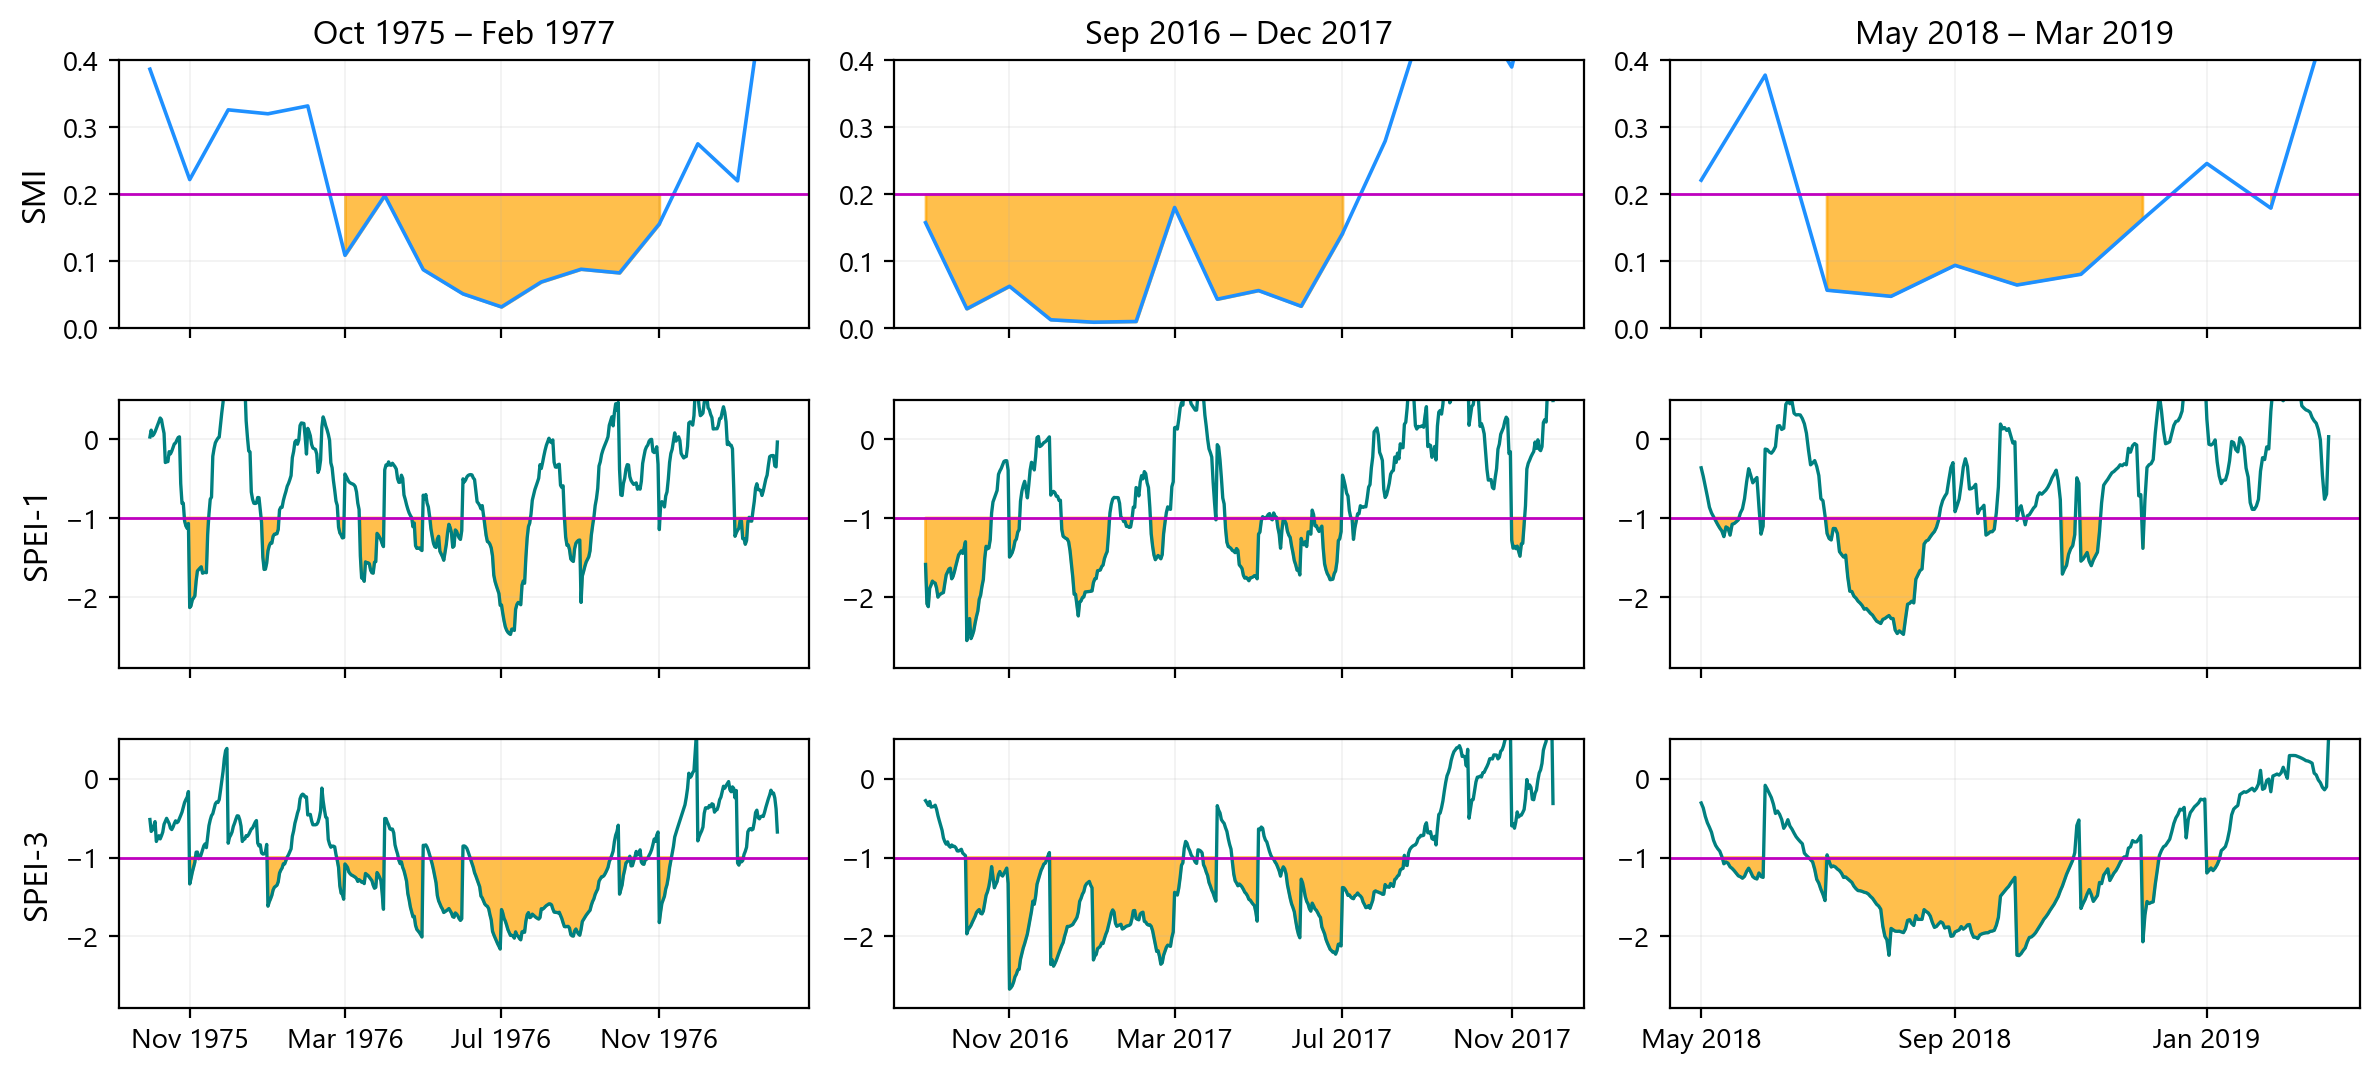

In [132]:
n_events = len(drought_ADM_plot)
fig, axes = plt.subplots(3, n_events, figsize=(4.0 * n_events, 5.5), sharex='col', dpi=200)

# Handle shape in case of single event
if n_events == 1:
    axes = axes[:, np.newaxis]

lat_min, lat_max, lon_min, lon_max = 5525000, 5600000, 550000, 700000

for col, row in enumerate(drought_ADM_plot.itertuples()):

    start_date = row.start_month
    end_date = row.end_month

    # Extract time series for the drought region
    smi_ts = sMI['SMI'].sel(time=slice(start_date, end_date),
                            lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max)
               ).mean(dim=['lat', 'lon']).to_series().rolling(window=1).mean()

    spei1_ts = spei_1_da['spei_1'].sel(time=slice(start_date, end_date),
                            lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max)
               ).mean(dim=['lat', 'lon']).to_series().rolling(window=1).mean()

    spei3_ts = spei_3_da['spei_3'].sel(time=slice(start_date, end_date),
                            lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max)
               ).mean(dim=['lat', 'lon']).to_series().rolling(window=1).mean()

    # --- Plot SMI ---
    ax_smi = axes[0, col]
    ax_smi.plot(smi_ts, color='dodgerblue', label='SMI', linewidth=1.3)
    ax_smi.fill_between(smi_ts.index, smi_ts, 0.2, where=(smi_ts <= 0.2), color='orange', alpha=0.7)
    ax_smi.axhline(0.2, color='m', lw=1.0)
    ax_smi.set_ylim(0,0.4)
    if col == 0:
        ax_smi.set_ylabel('SMI', fontsize=12)
    ax_smi.set_title(f'{start_date.strftime("%b %Y")} – {end_date.strftime("%b %Y")}')
    ax_smi.grid(True, lw=0.1)

    # --- Plot SPEI-1 ---
    ax_spei1 = axes[1, col]
    ax_spei1.plot(spei1_ts, color='teal', linewidth=1.2)
    ax_spei1.fill_between(spei1_ts.index, spei1_ts, -1.0, where=(spei1_ts < -1.0), color='orange', alpha=0.7)
    ax_spei1.axhline(-1, color='m', lw=1.0)
    ax_spei1.set_ylim(-2.9,0.5)
    if col == 0:
        ax_spei1.set_ylabel('SPEI-1', fontsize=12)
    ax_spei1.grid(True, lw=0.1)

    # --- Plot SPEI-3 ---
    ax_spei3 = axes[2, col]
    ax_spei3.plot(spei3_ts, color='teal', linewidth=1.2)
    ax_spei3.fill_between(spei3_ts.index, spei3_ts, -1.0, where=(spei3_ts <= -1), color='orange', alpha=0.7)
    ax_spei3.axhline(-1, color='m', lw=1.0)
    ax_spei3.set_ylim(-2.9,0.5)
 
    if col == 0:
        ax_spei3.set_ylabel('SPEI-3', fontsize=12)
    ax_spei3.grid(True, lw=0.1)
    ax_spei3.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    ax_spei3.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Final formatting
plt.tight_layout(h_pad=2)
#plt.suptitle("SMI and SPEI Comparisons During Major Drought Events", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.93)
plt.show()

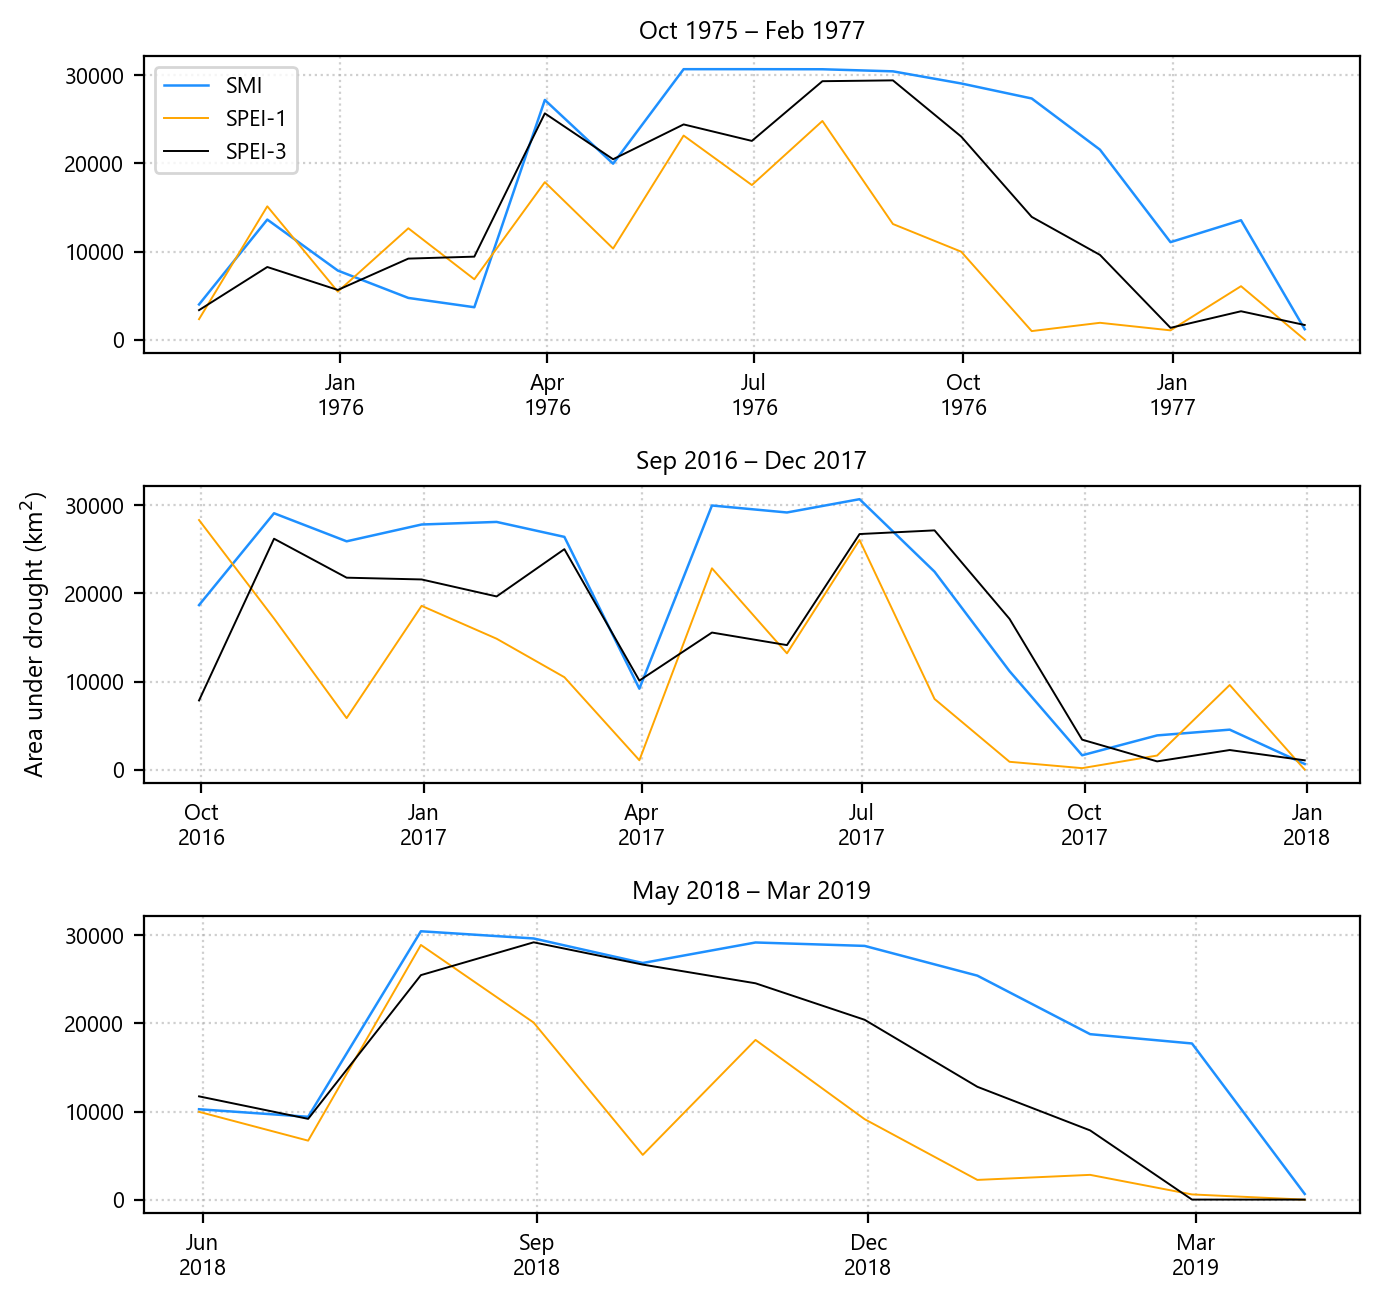

In [128]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ── Figure layout: one column, n rows ────────────────────────────────────
n_events  = len(drought_ADM_plot)
fig, axes = plt.subplots(
    n_events, 1,                       # n rows, 1 column
    figsize=(7, 2.2 * n_events),      # height scales with number of rows
    sharey=True, dpi=200
)
if n_events == 1:                      # when only one event, axes is a single Axes
    axes = [axes]

# ── Set spacing between figures ────────────────────────────────────────────────────
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots

# ── Loop over events ─────────────────────────────────────────────────────
for idx, row in enumerate(drought_ADM_plot.itertuples()):
    start_time, end_time = row.start_month, row.end_month
    ax = axes[idx]

    # ---- slice data to the event window --------------------------------
    tx_sMI   = sMI.sel(time=slice(start_time, end_time))['SMI']
    tx_sPEI1 = spei_1_da.sel(time=slice(start_time, end_time))['spei_1']
    tx_sPEI3 = spei_3_da.sel(time=slice(start_time, end_time))['spei_3']

    # ---- mask → pixel count → km² --------------------------------------
    area_smi   = (tx_sMI  < 0.20 ).sum(dim=['lat', 'lon']).to_series()
    area_spei1 = (tx_sPEI1 < -1.00 ).sum(dim=['lat', 'lon']).to_series()
    area_spei3 = (tx_sPEI3 < -1.00 ).sum(dim=['lat', 'lon']).to_series()

    #Convert pixel counts to km². x grid size (4 sq. km)
    area_smi   = area_smi.resample('ME').mean()   * 4
    area_spei1 = area_spei1.resample('ME').mean() * 4
    area_spei3 = area_spei3.resample('ME').mean() * 4

    # ---- overlay the three indices -------------------------------------
    ax.plot(area_smi,   lw=0.9, color='dodgerblue', label='SMI')
    ax.plot(area_spei1, lw=0.7, color='orange',       label='SPEI-1')
    ax.plot(area_spei3, lw=0.7, color='k', label='SPEI-3')

    #ax.axhline(0, color='k', lw=0.7)
    ax.set_title(f"{start_time:%b %Y} – {end_time:%b %Y}", fontsize=9)
    ax.grid(ls=':', alpha=0.6)

    # X-axis formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    ax.tick_params(axis='both', labelsize=8)

    # Y-label only on the first (top) row
    if idx == 1:
        ax.set_ylabel('Area under drought (km$^2$)', fontsize=9)

# One legend for the whole figure (last axis is fine)
axes[0].legend(loc='upper left', ncols=1, fontsize=8)

fig.tight_layout()
plt.show()


#### Meteo anomalies during droughts

In [127]:
pre_monthly = pre.resample(time='ME').sum()
pet_monthly = pet.resample(time='ME').sum()

#anomalies during droughts